<div align="center">
    <h1>Atividade 4 - Caio Sousa Mendes e Felipe Baqueiro </h1>
    <h3>ENGG67- T01 - Tópicos especiais em engenharia de computação </h3>
    <h4>Prof.: Antônio C. L. Fernandes Júnior</h4>
</div>

 <br>
 
<font size="3"><b> Importação do banco de dados "mobile-price" para classificação utilizando Árvore de decisão com método de validação cruzada k-fold.</b>  </font>  

O banco de dados contém informações sobre os recursos de celulares e seu preço de venda organizado em faixa de valores (0 - 3), 0 para o mais barato até 3 para o preço mais caro. Então, o objetivo é prever uma faixa de preço para novos celulares.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.metrics import accuracy_score 
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

dados = pd.read_csv('./mobile-price.csv')

print("Quantidade de objetos do banco de dados:", dados.shape[0])
print("Quantidade de atributos do banco de dados:", dados.shape[1])

dados.sample(5)

Quantidade de objetos do banco de dados: 2000
Quantidade de atributos do banco de dados: 21


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
482,1330,1,1.3,1,14,0,3,0.3,83,5,...,980,1262,463,14,6,11,0,0,1,0
852,814,1,1.1,1,2,0,41,0.8,177,2,...,1092,1406,1944,16,6,12,1,0,0,1
1159,504,0,2.8,1,0,0,40,0.5,178,3,...,626,1195,470,6,0,16,1,0,0,0
774,969,0,2.4,0,0,0,45,0.3,124,7,...,491,589,404,18,5,19,1,0,1,0
1254,1083,0,1.0,0,6,0,52,0.9,126,2,...,925,1469,681,19,18,19,1,1,1,0


 <br>
<font size="4">  
    <b >Checando se tem valores faltando</b>
</font> 

In [2]:
dados.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Não há valores ausentes

 <br>
<font size="4">  
    <b >Histograma dos atributos</b>
</font> 

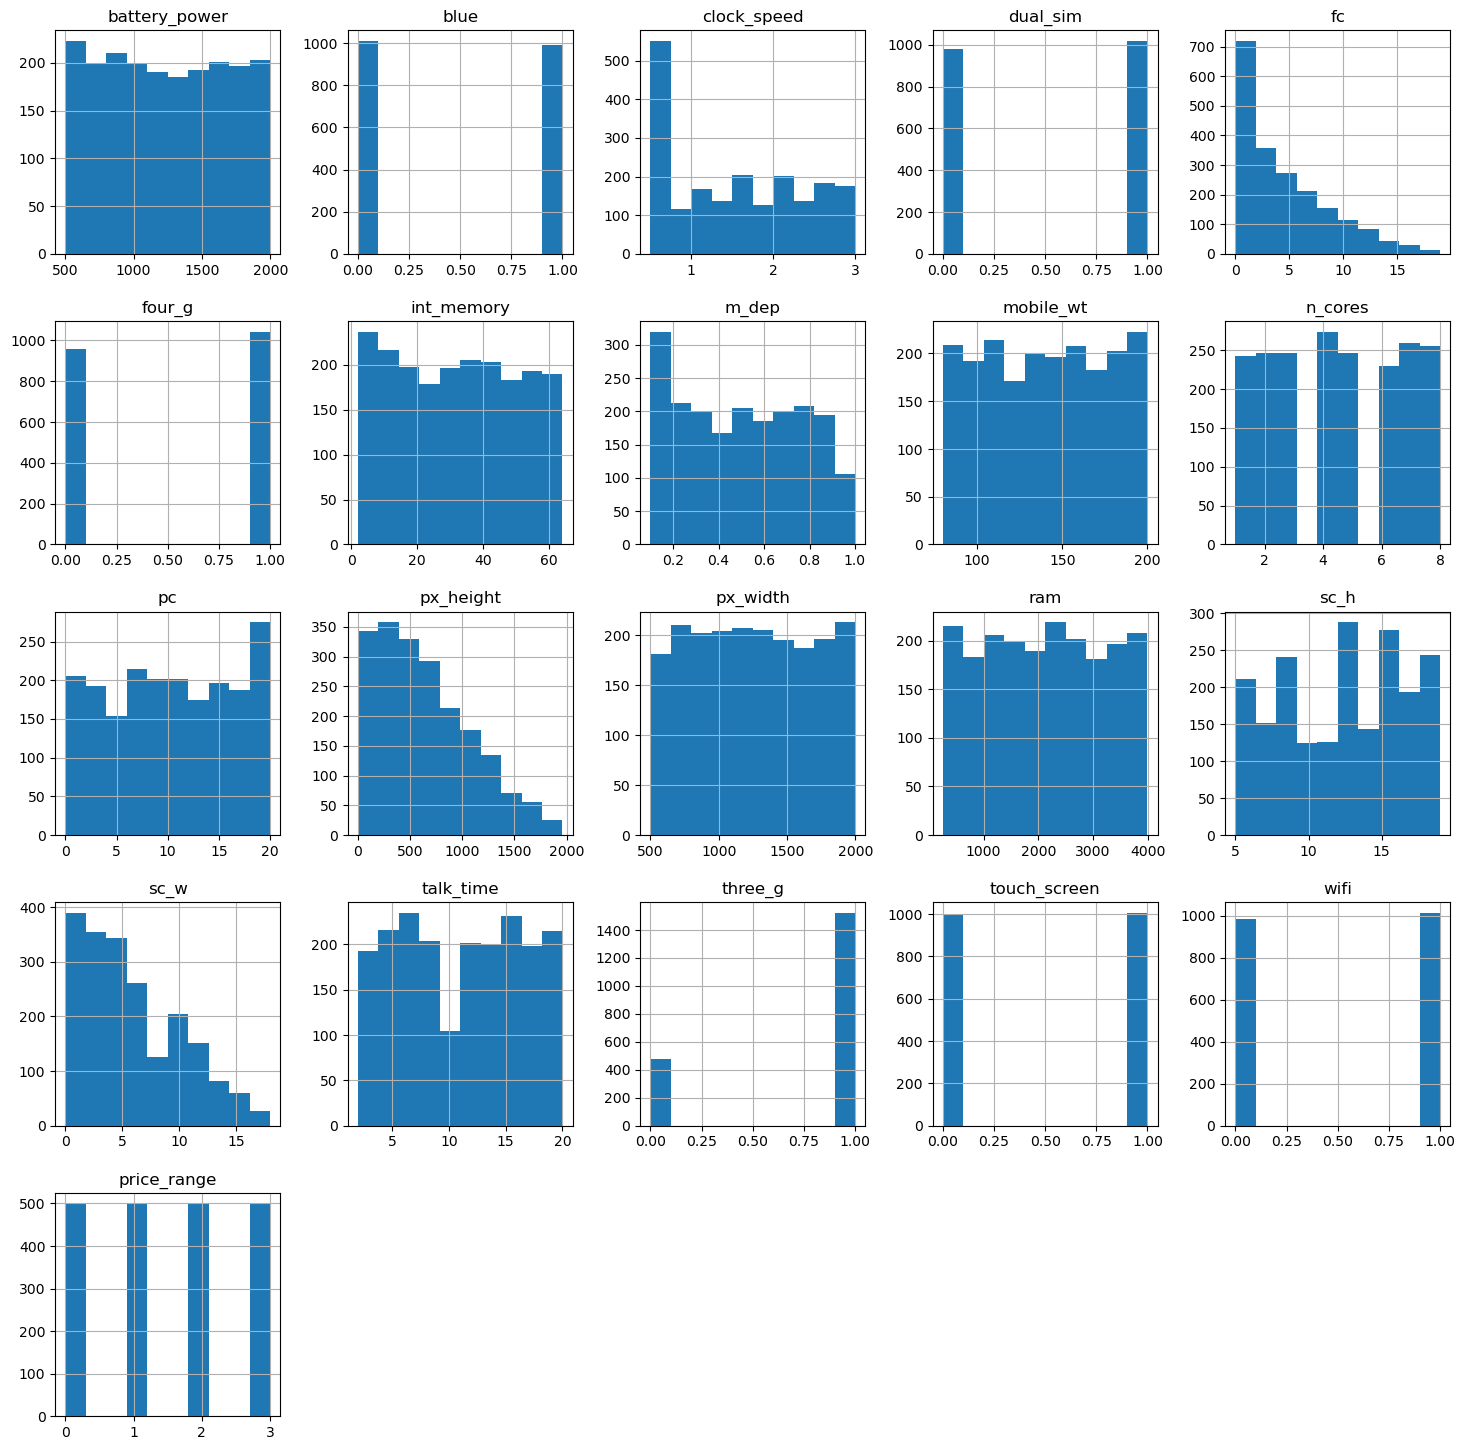

In [3]:
dados.hist(figsize=(18,18))
plt.show()

 <br>
<font size="4">  
    <b >Checando a distribuição do atributo alvo</b>
</font> 

Text(0.5, 1.0, 'Atributo alvo: price_range')

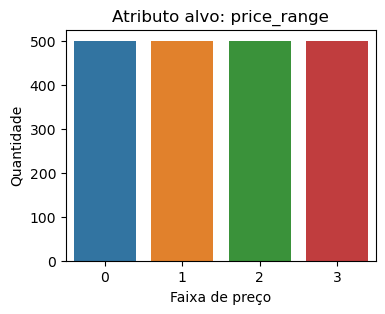

In [4]:
fig1,histogramaPreco = plt.subplots(figsize=(4,3))
sns.countplot(x = dados['price_range'])
histogramaPreco.set_xlabel('Faixa de preço')
histogramaPreco.set_ylabel('Quantidade')
histogramaPreco.set_title('Atributo alvo: price_range')

Com o histograma acima podemos observar que a classe alvo está igualmente distribuida.

 <br>
<font size="4">  
    <b >Correlação dos atributos</b>
</font> 

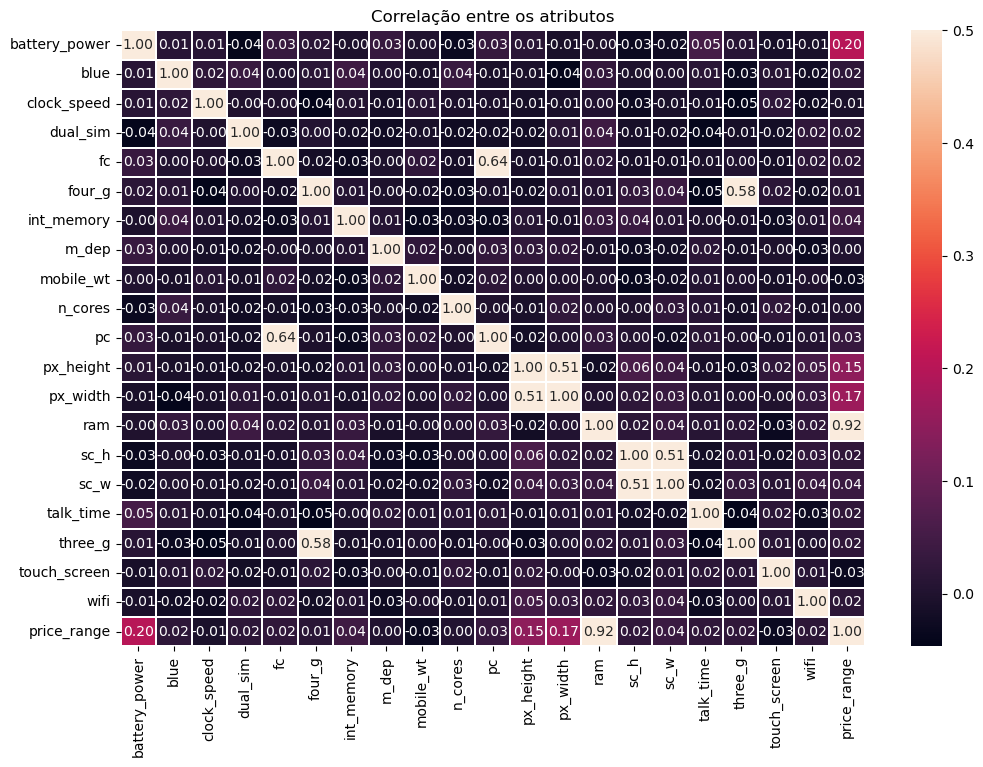

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(dados.corr(), vmax=.5, annot=True, fmt='.2f', linewidths=.1,)
plt.title('Correlação entre os atributos')
plt.show()

Com o gráfico acima, podemos observar que os atributos com as maiores correlações com o atributo alvo (price_range):

ram: 0.92

battery_power: 0.20

px_width: 0.17

px_height: 0.15



 <br>
<font size="4">  
    <b>Boxplot dos atributos</b>
</font> 

Separação dos atributos numéricos do banco de dados:

In [18]:
num_cols = pd.DataFrame (x, columns= ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'])

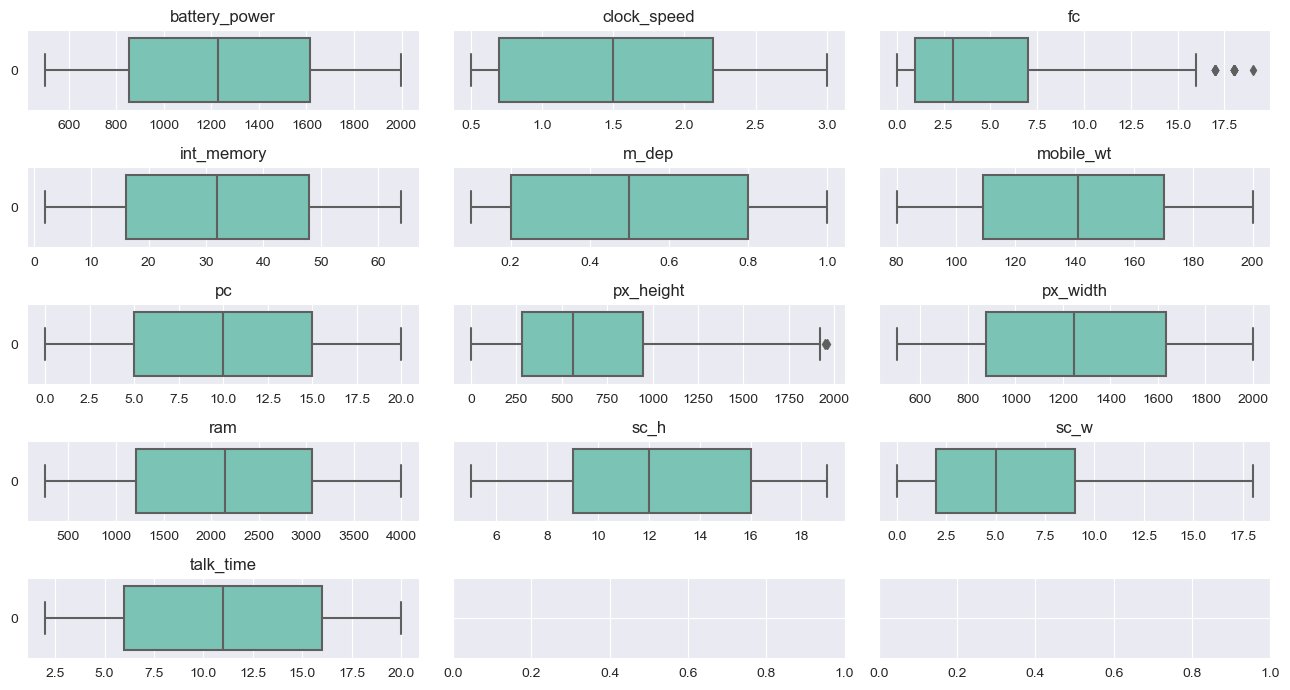

In [21]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(5, 3, sharey=True, figsize=(13,7))
axs = axs.flatten()

for i, data in enumerate(num_cols):
    sns.boxplot(data=x[data], orient='h', color ='#6fcfbc', ax=axs[i])
    axs[i].set_title(data)
        
plt.tight_layout()


Com os gráficos dos boxsplots, conseguimos visualizar presença de outliers nos atributos "px_height" e"fc". Para o atributo "sc_w" não consta outliers, mas o limite superior está distante do 3º quartil, podendo contém também outliers.

A correlação dos atributos "fc" e "sc_w" com o atributo alvo para a classificação é pequena. Porém, para o atributo "px_height" é a quarta maior correlação, assim podendo influenciar no desempenho do modelo.

 <br>
<font size="4">  
    <b >Separação do atributo alvo</b>
</font> 

In [11]:
y = dados['price_range']
x = dados.drop(['price_range'], axis = 1)

<br>
<font size="4">  
    <b>Separação 70% do banco de dados para treinamento e 30% para teste</b>
</font> 

In [12]:
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)

<br>
<font size="4">  
    <b>Validação cruzada k-fold, com 5 partições (k = 5)</b>
</font> 

In [32]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

modelo = tree.DecisionTreeClassifier()

k = 5
kfold  = KFold(n_splits = k , shuffle=True)

scores = cross_val_score(modelo, train_X, train_y, cv=kfold, scoring='accuracy')
print("Lista de acurácias:\n", scores)  
print("Acurácia média: ", scores.mean())

Lista de acurácias:
 [0.74642857 0.85357143 0.83928571 0.83571429 0.82857143]
Acurácia média:  0.8207142857142857


<br>
<font size="4">  
    <b>Treinamento do modelo</b>
</font> 

In [36]:
modelo.fit(train_X, train_y)

pred = modelo.predict(test_X)

print("Acurácia com dados de teste:", accuracy_score(test_y, pred))

Acurácia com dados de teste: 0.8383333333333334


<br>
<font size="4">  
    <b>Matriz de confusão</b>
</font> 

Text(0.5, 1.0, 'Matriz de confusão')

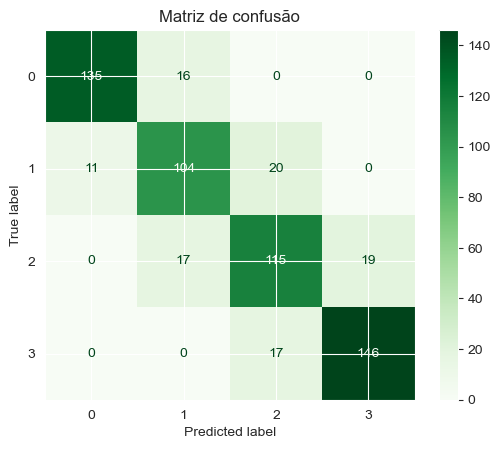

In [34]:
ConfusionMatrixDisplay.from_estimator(modelo, test_X, test_y, colorbar=True, cmap='Greens')
plt.title('Matriz de confusão')

A diagonal principal nos mostra a quantidade das predições corretas para cada valor do atributo alvo.

<br>
<font size="4">  
    <b>Precision, Recall, F-measure e Support de cada classe alvo</b>
</font> 

In [37]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       151
           1       0.76      0.80      0.78       135
           2       0.79      0.74      0.76       151
           3       0.89      0.90      0.89       163

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



A partir das informações, a precisão nos acertos teve maior destaque na predição correta do atributo alvo "price_range" para os valores 0 e 3.

<br>
<font size="4">  
    <b>Conclusão</b>
</font> 

A máquina de aprendizado treinado obteve uma acurácia média de 82% nas predições corretas. A precisão nos acertos teve maior destaque na predição correta do atributo alvo "price_range" para os valores 0 e 3.
Com os atributos alvos já balanceados, a remoção de outliers dos atributos detectados pode ser feito para melhorar o desempenho do modelo.